Let's try to obtain genre of a computer games using descriptions. Let's parse Russian site about computer games kanobu.ru

## Links to all games

In [168]:
import requests     
import numpy as np   
import pandas as pd  
import time    
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

In [2]:
def parsing():
    for page_index in tqdm(range(0, 2871)):
        link = "https://kanobu.ru/games/popular/?page=" + str(page_index)
        response = requests.get(link)
        if response:
            soup = BeautifulSoup(response.content, 'html.parser')
            games = soup.findAll(lambda tag: tag.name == 'a' and tag.get('class') == ['c-game__img'])
            links = []
            for i in games:
                links.append(i.attrs['href'])
            f = open('links.txt', 'a')
            for i in links:
                f.write(i + '\n')
            f.close()
        time.sleep(1)

In [5]:
#disabeled this to avoid accidentally running again
#parsing() 

100%|████████████████████████████████████████████████████████████████████████████| 2339/2339 [1:23:26<00:00,  2.14s/it]


## Information about all games

In [3]:
f = open('links.txt','r')
links = f.read().split('\n')

In [4]:
def get_info_games():
    count = 0 
    for i in tqdm(links):
        link = 'https://kanobu.ru' + i
        
        try:
            response = requests.get(link)
            soup = BeautifulSoup(response.content, 'html.parser')
            try:
                genres = soup.find(lambda tag: tag.name == 'ul' and tag.get('class') == ['genres']).text.strip()
            except:
                continue
            try:
                description = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['wrapShortDescr']).text.strip()
            except:
                description = ""
            name = soup.find(lambda tag: tag.name == 'h1' and tag.get('class') == ['game-header']).text.strip()
            f = open('descriptions.txt', 'a', encoding='utf-8')
            f.write(name + '\t' + genres + '\t' + description + '\n')
            f.close()
        except: 
            f = open("fails.txt", 'a')
            f.write(i + '\n')
            f.close()
            time.sleep(60)

In [5]:
#get_info_games()

100%|██████████████████████████████████████████████████████████████████████████| 18274/18274 [6:38:46<00:00,  1.31s/it]


In [9]:
f = open('fails.txt', 'r')
links = f.read().split('\n')
get_info_games()

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [01:18<00:00,  1.16s/it]


## Preprocessing

In [5]:
f = open('descriptions.txt', 'r', encoding = 'utf-8')
all_games = []
game = f.readline()
while game:
    parts = game.split('\t')
    if (parts[2] != "\n"):
        all_games.append({"Name": parts[0], 'Genres':parts[1], 'Description': parts[2]})
    game = f.readline()
f.close()

In [6]:
data = pd.DataFrame(all_games)

In [7]:
data

,Name,Genres,Description
0,The Elder Scrolls 5: Skyrim,Ролевые,The Elder Scrolls V: Skyrim - это приключенчес...
1,Grand Theft Auto 5,Экшен Шутеры,Grand Theft Auto V (она же GTA 5 или GTA V) — ...
2,Grand Theft Auto 4,Экшен,Grand Theft Auto IV - это четвертая часть ганг...
3,Minecraft,Экшен Симуляторы Приключения Пазлы,Minecraft - это инди-игра в жанре песочницы с ...
4,Grand Theft Auto: San Andreas,Экшен,Grand Theft Auto: San Andreas - пятая часть се...
...,...,...,...
24054,Clayside,Пазлы,"Clayside - головоломка, где игрок строит дом с..."
24055,The Tarot's Misfortune,Приключения,"The Tarot's Misfortune - игра в жанре ""я ищу"",..."
24056,Gentlemen... Ricochet!,Пазлы,Gentlemen... Ricochet!\n
24057,Alternate Jake Hunter: DAEDALUS The Awakening ...,Приключения,Alternate Jake Hunter: DAEDALUS The Awakening ...


In [8]:
data['Legth'] = [len(x.split(' ')) for x in data['Description']]

In [9]:
data[data['Legth']<20]

,Name,Genres,Description,Legth
273,Dirt 3,Гонки,Colin McRae: DiRT 3 - это очередная часть знам...,17
325,Risen 2: Dark Water,Экшен Ролевые,"Risen II: Dark Water - сиквел ""готичной"" ролев...",16
357,FIFA 12,Симуляторы Спорт,FIFA 12 - очередная часть знаменитого футбольн...,11
386,SHOFER Race Driver,Симуляторы Аркады Гонки,SHOFER Race Driver - это аркадный гоночный сим...,15
451,Rayman Legends,Аркады,Rayman Legends - продолжение яркой и забавной ...,18
...,...,...,...,...
24050,Moses: From Egypt to the Promised Land,Экшен Ролевые Симуляторы Приключения,Moses: From Egypt to the Promised Land\n,7
24051,Ridiculous Catapult Simulator,Стратегии Симуляторы,Ridiculous Catapult Simulator\n,3
24052,SILENT DOOM,Экшен Симуляторы Приключения,SILENT DOOM\n,2
24056,Gentlemen... Ricochet!,Пазлы,Gentlemen... Ricochet!\n,2


In [10]:
data = data[data['Legth']>20]

Because some games have several genres we are going to create sevelar models instead of one. Each of them answers the question like "Is this game a race?", "Is this game an action?" and so one. So we are going to find all genres. Each model is a binary classification and evaluate them separately.

In [11]:
data.drop(['Legth'], axis = 1, inplace = True)
data

C:\Users\kogti\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Name,Genres,Description
0,The Elder Scrolls 5: Skyrim,Ролевые,The Elder Scrolls V: Skyrim - это приключенчес...
1,Grand Theft Auto 5,Экшен Шутеры,Grand Theft Auto V (она же GTA 5 или GTA V) — ...
2,Grand Theft Auto 4,Экшен,Grand Theft Auto IV - это четвертая часть ганг...
3,Minecraft,Экшен Симуляторы Приключения Пазлы,Minecraft - это инди-игра в жанре песочницы с ...
4,Grand Theft Auto: San Andreas,Экшен,Grand Theft Auto: San Andreas - пятая часть се...
...,...,...,...
24047,Empathy,Приключения,Empathy: Path of Whispers - это приключенческа...
24053,Bad Apples,Пазлы,"Bad Apples - головоломка в жанре ""3 в ряд"". Вы..."
24054,Clayside,Пазлы,"Clayside - головоломка, где игрок строит дом с..."
24055,The Tarot's Misfortune,Приключения,"The Tarot's Misfortune - игра в жанре ""я ищу"",..."


In [12]:
all_genres = []
for i in data['Genres'].unique():
    current = i.split(' ')
    for j in current:
        if j in all_genres:
            continue
        else:
            all_genres.append(j)
all_genres  

['Ролевые',
 'Экшен',
 'Шутеры',
 'Симуляторы',
 'Приключения',
 'Пазлы',
 'Гонки',
 'Стратегии',
 'MMO',
 'MOBA',
 'Аркады',
 'Файтинги',
 'Спорт']

In [13]:
for i in all_genres:
    data[i] = [i in x for x in np.array(data['Genres'])]
    data[i] = data[i].map({True:1, False:0})

<ipython-input-13-ffe3676a0a0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = [i in x for x in np.array(data['Genres'])]
<ipython-input-13-ffe3676a0a0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = data[i].map({True:1, False:0})


In [14]:
data

,Name,Genres,Description,Ролевые,Экшен,Шутеры,Симуляторы,Приключения,Пазлы,Гонки,Стратегии,MMO,MOBA,Аркады,Файтинги,Спорт
0,The Elder Scrolls 5: Skyrim,Ролевые,The Elder Scrolls V: Skyrim - это приключенчес...,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Grand Theft Auto 5,Экшен Шутеры,Grand Theft Auto V (она же GTA 5 или GTA V) — ...,0,1,1,0,0,0,0,0,0,0,0,0,0
2,Grand Theft Auto 4,Экшен,Grand Theft Auto IV - это четвертая часть ганг...,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Minecraft,Экшен Симуляторы Приключения Пазлы,Minecraft - это инди-игра в жанре песочницы с ...,0,1,0,1,1,1,0,0,0,0,0,0,0
4,Grand Theft Auto: San Andreas,Экшен,Grand Theft Auto: San Andreas - пятая часть се...,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24047,Empathy,Приключения,Empathy: Path of Whispers - это приключенческа...,0,0,0,0,1,0,0,0,0,0,0,0,0
24053,Bad Apples,Пазлы,"Bad Apples - головоломка в жанре ""3 в ряд"". Вы...",0,0,0,0,0,1,0,0,0,0,0,0,0
24054,Clayside,Пазлы,"Clayside - головоломка, где игрок строит дом с...",0,0,0,0,0,1,0,0,0,0,0,0,0
24055,The Tarot's Misfortune,Приключения,"The Tarot's Misfortune - игра в жанре ""я ищу"",...",0,0,0,0,1,0,0,0,0,0,0,0,0


## NLP

In [153]:
y = data[['Ролевые','Экшен','Шутеры','Симуляторы','Приключения','Пазлы','Гонки','Стратегии','MMO','MOBA','Аркады','Файтинги','Спорт']]
x = data[['Description', 'Name']]

In [154]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 18)

In [155]:
vectorizer = TfidfVectorizer(stop_words = stopwords.words('russian'), ngram_range=(1,2), min_df = 0.003, max_df = 0.004, norm = None)
features = vectorizer.fit_transform(x_train['Description']).todense()
x_train_features = pd.DataFrame(features, columns=vectorizer.get_feature_names())
x_train_features

,13,14,18,2010,25,2d,ace,age of,ai,all,...,экипировку,экрана,элементов,эпизодов,это мобильная,это ролевой,это сиквел,это тактическая,это третья,этому
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
arrays = []
for index, row in y_train.iterrows():
    arrays.append(np.array(row))
y_train_features = pd.DataFrame(data=arrays, columns=y_train.columns)
y_train_features

,Ролевые,Экшен,Шутеры,Симуляторы,Приключения,Пазлы,Гонки,Стратегии,MMO,MOBA,Аркады,Файтинги,Спорт
0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13059,1,0,0,0,0,0,0,0,0,0,0,0,0
13060,1,0,0,0,0,0,0,0,0,0,0,0,0
13061,0,0,0,0,0,1,0,1,0,0,0,0,0
13062,1,0,0,0,0,0,0,1,0,0,0,0,0


In [157]:
features = vectorizer.transform(x_test['Description']).todense()
x_test_features = pd.DataFrame(features, columns=vectorizer.get_feature_names())
x_test_features

,13,14,18,2010,25,2d,ace,age of,ai,all,...,экипировку,экрана,элементов,эпизодов,это мобильная,это ролевой,это сиквел,это тактическая,это третья,этому
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,6.627545,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5594,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5595,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5596,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5597,0.0,0.0,0.0,0.0,6.526448,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
arrays = []
for index, row in y_test.iterrows():
    arrays.append(np.array(row))
y_test_features = pd.DataFrame(data=arrays, columns=y_test.columns)
y_test_features

,Ролевые,Экшен,Шутеры,Симуляторы,Приключения,Пазлы,Гонки,Стратегии,MMO,MOBA,Аркады,Файтинги,Спорт
0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5594,0,0,0,1,0,0,0,1,0,0,0,0,0
5595,0,0,0,0,0,1,0,0,0,0,0,0,0
5596,0,0,0,0,0,0,0,1,1,0,0,0,0
5597,0,0,0,1,0,0,0,0,0,0,0,0,0


## Logistic Regression

In [204]:
def LR(column):
    
    clf = LogisticRegression(random_state=0).fit(x_train_features, y_train_features[column])
    result = clf.predict(x_test_features)
    featureImportance = pd.DataFrame({"feature": x_train_features.columns, 
                                      "importance": clf.coef_[0]})
    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)
    featureImportance["importance"][:50].plot(kind='bar', figsize=(10, 6))
    print("Accuracy: " +  str(accuracy_score(y_test_features[column], result)))

Accuracy: 0.8647972852295053


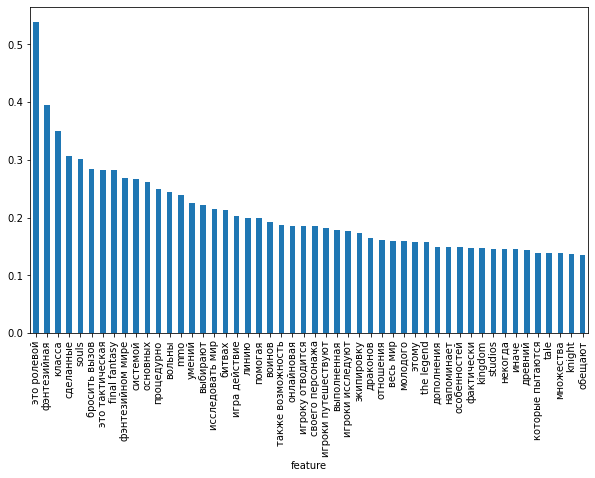

In [207]:
LR('Ролевые')

Accuracy: 0.7621003750669763


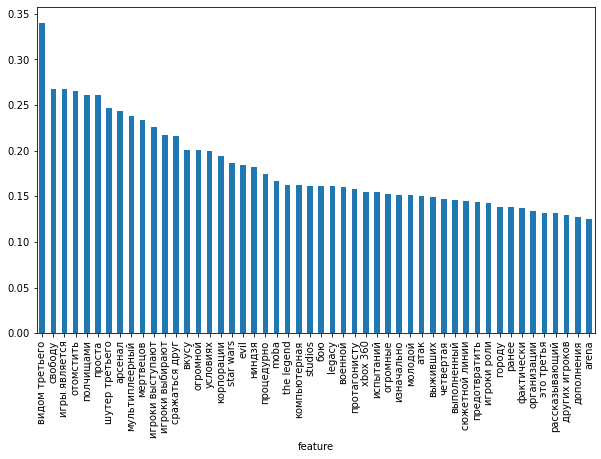

In [208]:
LR('Экшен')

Accuracy: 0.9148062153956064


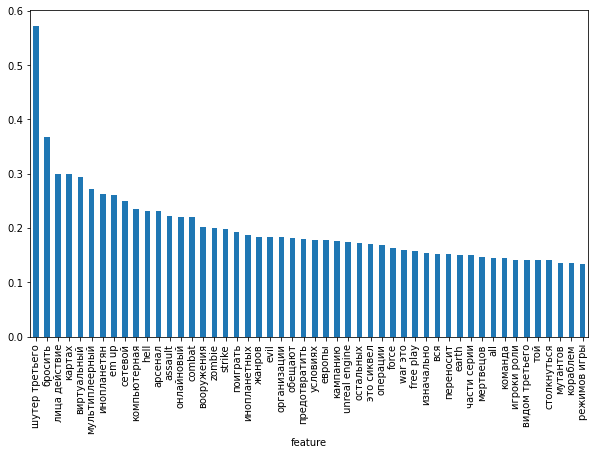

In [209]:
LR('Шутеры')

Accuracy: 0.882836220753706


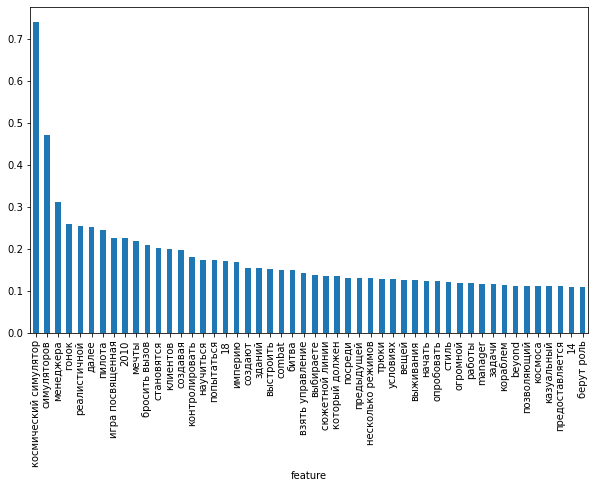

In [210]:
LR('Симуляторы')

Accuracy: 0.7897838899803536


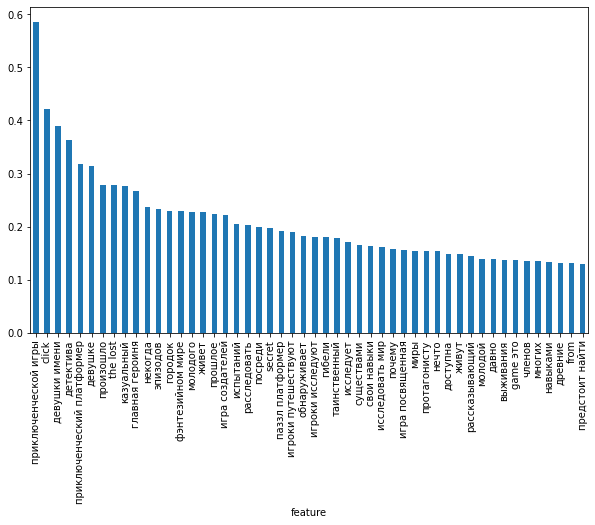

In [211]:
LR('Приключения')

Accuracy: 0.8923021968208609


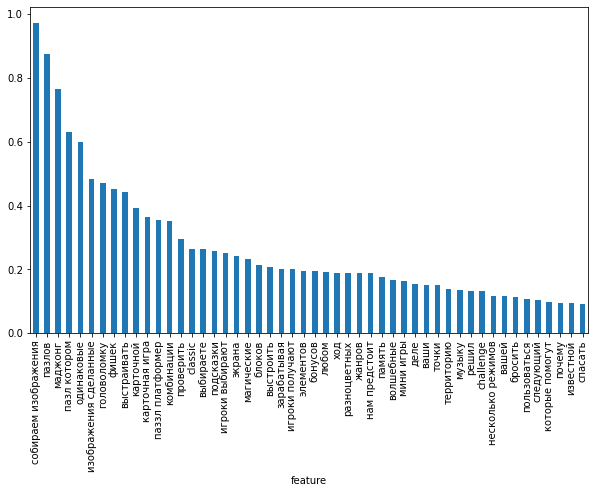

In [212]:
LR('Пазлы')

Accuracy: 0.962671905697446


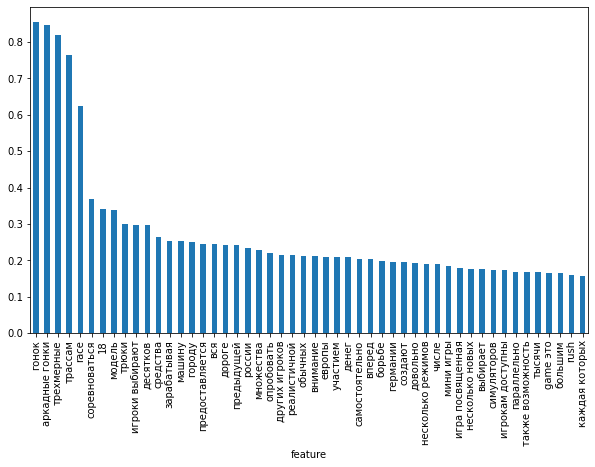

In [213]:
LR('Гонки')

Accuracy: 0.8564029290944811


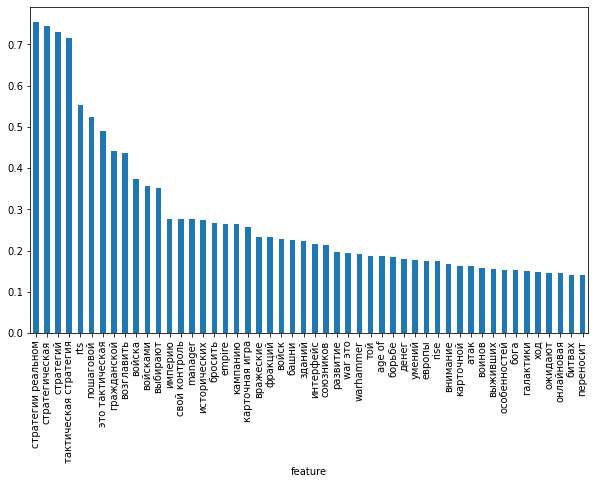

In [214]:
LR('Стратегии')

Accuracy: 0.9637435256295767


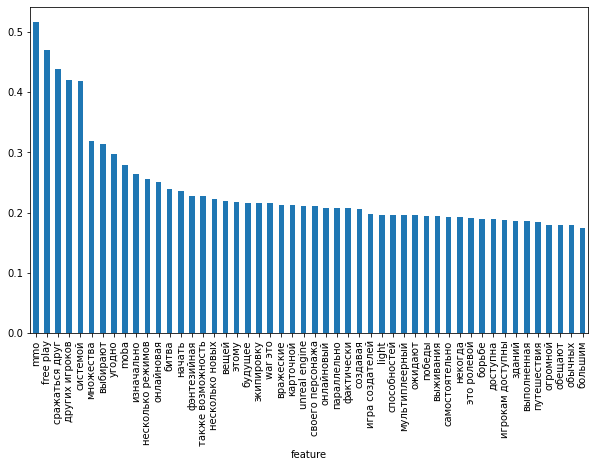

In [215]:
LR('MMO')

Accuracy: 0.9969637435256296


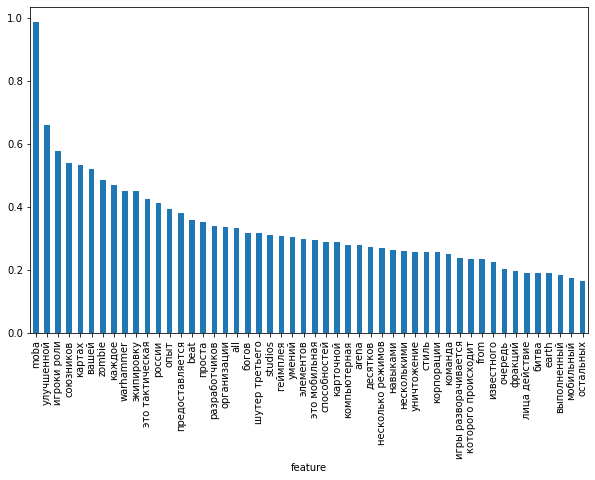

In [216]:
LR('MOBA')

Accuracy: 0.7940703697088766


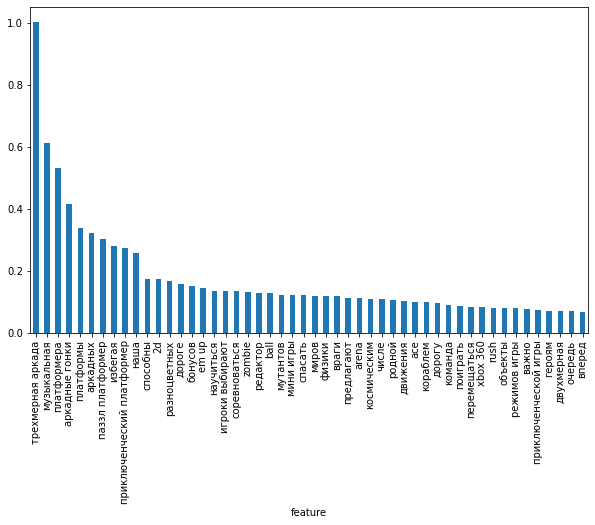

In [217]:
LR('Аркады')

Accuracy: 0.9942846936953027


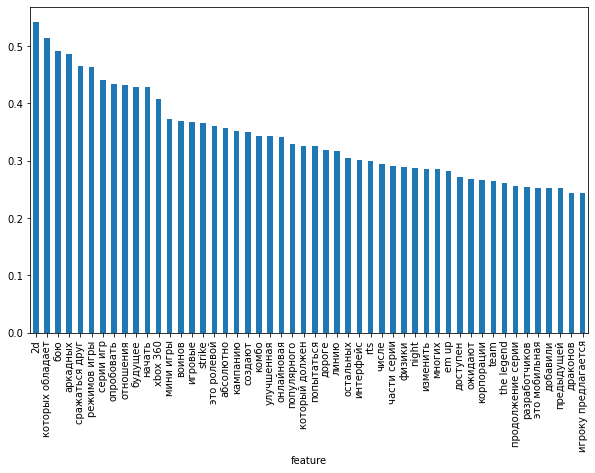

In [218]:
LR('Файтинги')

Accuracy: 0.9691016252902304


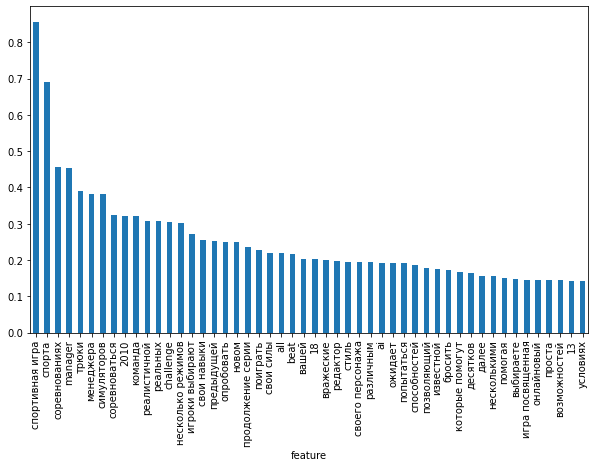

In [219]:
LR('Спорт')